# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:

import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop

In [4]:
import optuna

## Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image.

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format).

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../../data/processed/mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

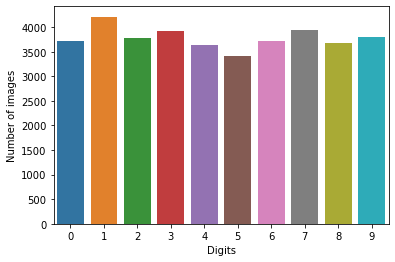

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

### Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel.

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices.

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

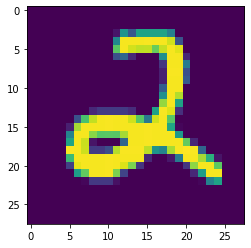

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

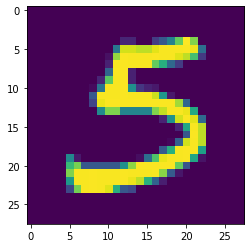

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

## Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model_2.h5'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # Note, with this configuration, we sample different filters, kernels
        # stride etc, for each convolutional layer that we add

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters_{}'.format(i), [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size{}'.format(i), [3, 5]),
            strides=trial.suggest_categorical('strides{}'.format(i), [1, 2]),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units{}'.format(i), 5, 512),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study_2"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [17]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2022-11-02 06:25:16,418] A new study created in RDB with name: cnn_study_2
2022-11-02 06:25:16.626478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 17s 60ms/step - loss: 0.2522 - accuracy: 0.9194 - val_loss: 0.0948 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 15s 58ms/step - loss: 0.0710 - accuracy: 0.9777 - val_loss: 0.0710 - val_accuracy: 0.9765
Epoch 3/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0464 - accuracy: 0.9851 - val_loss: 0.0935 - val_accuracy: 0.9762


[I 2022-11-02 06:26:07,150] Trial 0 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 313, 'optimizer_name': 'Adam', 'learning_rate': 0.0030866103653692397}. Best is trial 0 with value: 0.976190447807312.


Epoch 1/3
266/266 [==============================] - 8s 28ms/step - loss: 0.2751 - accuracy: 0.9125 - val_loss: 0.1668 - val_accuracy: 0.9481
Epoch 2/3
266/266 [==============================] - 5s 19ms/step - loss: 0.1156 - accuracy: 0.9636 - val_loss: 0.1264 - val_accuracy: 0.9601
Epoch 3/3
266/266 [==============================] - 6s 21ms/step - loss: 0.0817 - accuracy: 0.9735 - val_loss: 0.1063 - val_accuracy: 0.9653


[I 2022-11-02 06:26:28,446] Trial 1 finished with value: 0.9653438925743103 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 3, 'units0': 54, 'units1': 194, 'activation1': 'relu', 'units2': 221, 'activation2': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.003917740237946297}. Best is trial 0 with value: 0.976190447807312.


Epoch 1/3
266/266 [==============================] - 21s 78ms/step - loss: 0.4310 - accuracy: 0.8810 - val_loss: 0.1799 - val_accuracy: 0.9492
Epoch 2/3
266/266 [==============================] - 22s 83ms/step - loss: 0.1202 - accuracy: 0.9646 - val_loss: 0.1103 - val_accuracy: 0.9677
Epoch 3/3
266/266 [==============================] - 18s 69ms/step - loss: 0.0771 - accuracy: 0.9779 - val_loss: 0.0803 - val_accuracy: 0.9765


[I 2022-11-02 06:27:32,842] Trial 2 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 1, 'units0': 75, 'optimizer_name': 'Adam', 'learning_rate': 0.0004817495426487812}. Best is trial 2 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 7s 25ms/step - loss: 0.1744 - accuracy: 0.9461 - val_loss: 0.0773 - val_accuracy: 0.9778
Epoch 2/3
266/266 [==============================] - 6s 21ms/step - loss: 0.0541 - accuracy: 0.9834 - val_loss: 0.0877 - val_accuracy: 0.9783
Epoch 3/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0688 - val_accuracy: 0.9815


[I 2022-11-02 06:27:53,310] Trial 3 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 127, 'optimizer_name': 'Adam', 'learning_rate': 0.007223760764614529}. Best is trial 3 with value: 0.9814814925193787.
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 10s 38ms/step - loss: 0.3939 - accuracy: 0.9087 - val_loss: 0.1392 - val_accuracy: 0.9640
Epoch 2/3
266/266 [==============================] - 9s 36ms/step - loss: 0.1004 - accuracy: 0.9729 - val_loss: 0.1088 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 10s 39ms/step - loss: 0.0744 - accuracy: 0.9795 - val_loss: 0.1262 - val_accuracy: 0.9735


[I 2022-11-02 06:28:25,315] Trial 4 finished with value: 0.9735449552536011 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 1, 'units0': 498, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004285699648795418, 'momentum': 0.45904007295396354}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 72s 268ms/step - loss: 2.3210 - accuracy: 0.1063 - val_loss: 2.3023 - val_accuracy: 0.1037
Epoch 2/3
266/266 [==============================] - 77s 290ms/step - loss: 2.3018 - accuracy: 0.1095 - val_loss: 2.3007 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 93s 349ms/step - loss: 2.3017 - accuracy: 0.1111 - val_loss: 2.3018 - val_accuracy: 0.1146


[I 2022-11-02 06:32:30,450] Trial 5 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'num_dense_layers': 3, 'units0': 378, 'units1': 467, 'units2': 463, 'optimizer_name': 'Adam', 'learning_rate': 0.008458644726745554}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 24s 88ms/step - loss: 2.6828 - accuracy: 0.1062 - val_loss: 2.3021 - val_accuracy: 0.0997
Epoch 2/3
266/266 [==============================] - 20s 76ms/step - loss: 2.3025 - accuracy: 0.1101 - val_loss: 2.3021 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 21s 78ms/step - loss: 2.3023 - accuracy: 0.1093 - val_loss: 2.3033 - val_accuracy: 0.0960


[I 2022-11-02 06:33:37,844] Trial 6 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'num_dense_layers': 3, 'units0': 422, 'units1': 437, 'activation1': 'relu', 'units2': 240, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.007221507376696458, 'momentum': 0.5462505220651009}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 35s 131ms/step - loss: 0.2053 - accuracy: 0.9340 - val_loss: 0.0851 - val_accuracy: 0.9757
Epoch 2/3
266/266 [==============================] - 27s 100ms/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 0.0930 - val_accuracy: 0.9751
Epoch 3/3
266/266 [==============================] - 28s 106ms/step - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.1087 - val_accuracy: 0.9730


[I 2022-11-02 06:35:10,391] Trial 7 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 2, 'units0': 418, 'units1': 409, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007768318073146631, 'momentum': 0.74715728728586}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 8s 30ms/step - loss: 0.1680 - accuracy: 0.9460 - val_loss: 0.0806 - val_accuracy: 0.9762
Epoch 2/3
266/266 [==============================] - 8s 32ms/step - loss: 0.0523 - accuracy: 0.9831 - val_loss: 0.0742 - val_accuracy: 0.9783
Epoch 3/3
266/266 [==============================] - 7s 28ms/step - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0800 - val_accuracy: 0.9786


[I 2022-11-02 06:35:35,658] Trial 8 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 389, 'optimizer_name': 'Adam', 'learning_rate': 0.00540924383066792}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 20s 72ms/step - loss: 11.9101 - accuracy: 0.1014 - val_loss: 10.2912 - val_accuracy: 0.0960
Epoch 2/3
266/266 [==============================] - 19s 71ms/step - loss: 9.2978 - accuracy: 0.1033 - val_loss: 12.1466 - val_accuracy: 0.0960
Epoch 3/3
266/266 [==============================] - 13s 48ms/step - loss: 8.7724 - accuracy: 0.1001 - val_loss: 10.8666 - val_accuracy: 0.1045


[I 2022-11-02 06:36:29,693] Trial 9 finished with value: 0.10449735820293427 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 156, 'units1': 145, 'units2': 416, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00788823546854365, 'momentum': 0.8928102073612976}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 26s 98ms/step - loss: 0.1913 - accuracy: 0.9404 - val_loss: 0.1235 - val_accuracy: 0.9643
Epoch 2/3
266/266 [==============================] - 26s 97ms/step - loss: 0.0767 - accuracy: 0.9771 - val_loss: 0.0822 - val_accuracy: 0.9778
Epoch 3/3
266/266 [==============================] - 24s 89ms/step - loss: 0.0695 - accuracy: 0.9798 - val_loss: 0.0779 - val_accuracy: 0.9778


[I 2022-11-02 06:37:47,884] Trial 10 finished with value: 0.9777777791023254 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 193, 'units1': 44, 'optimizer_name': 'Adam', 'learning_rate': 0.00621980645911461}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 6s 23ms/step - loss: 0.1758 - accuracy: 0.9433 - val_loss: 0.1016 - val_accuracy: 0.9706
Epoch 2/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0539 - accuracy: 0.9831 - val_loss: 0.0702 - val_accuracy: 0.9799
Epoch 3/3
266/266 [==============================] - 6s 23ms/step - loss: 0.0341 - accuracy: 0.9891 - val_loss: 0.0698 - val_accuracy: 0.9812


[I 2022-11-02 06:38:07,762] Trial 11 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 215, 'optimizer_name': 'Adam', 'learning_rate': 0.0058431191664021056}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 10s 38ms/step - loss: 0.2605 - accuracy: 0.9179 - val_loss: 0.1844 - val_accuracy: 0.9492
Epoch 2/3
266/266 [==============================] - 9s 33ms/step - loss: 0.1117 - accuracy: 0.9681 - val_loss: 0.1124 - val_accuracy: 0.9701
Epoch 3/3
266/266 [==============================] - 9s 34ms/step - loss: 0.1073 - accuracy: 0.9723 - val_loss: 0.1637 - val_accuracy: 0.9706


[I 2022-11-02 06:38:38,418] Trial 12 finished with value: 0.970634937286377 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 223, 'units1': 319, 'optimizer_name': 'Adam', 'learning_rate': 0.009544868743640116}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 7s 24ms/step - loss: 0.1825 - accuracy: 0.9416 - val_loss: 0.0918 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 5s 21ms/step - loss: 0.0550 - accuracy: 0.9832 - val_loss: 0.0856 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 5s 20ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0873 - val_accuracy: 0.9754


[I 2022-11-02 06:38:57,564] Trial 13 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 130, 'optimizer_name': 'Adam', 'learning_rate': 0.006258492890293699}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 [==============================] - 21s 79ms/step - loss: 0.1542 - accuracy: 0.9516 - val_loss: 0.0746 - val_accuracy: 0.9770
Epoch 2/3
266/266 [==============================] - 22s 82ms/step - loss: 0.0437 - accuracy: 0.9857 - val_loss: 0.0545 - val_accuracy: 0.9847
Epoch 3/3
266/266 [==============================] - 21s 79ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0530 - val_accuracy: 0.9868


[I 2022-11-02 06:40:03,774] Trial 14 finished with value: 0.9867724776268005 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 261, 'optimizer_name': 'Adam', 'learning_rate': 0.0028338694471854854}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 50s 186ms/step - loss: 0.1778 - accuracy: 0.9446 - val_loss: 0.0829 - val_accuracy: 0.9759
Epoch 2/3
266/266 [==============================] - 55s 207ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.0717 - val_accuracy: 0.9770
Epoch 3/3
266/266 [==============================] - 56s 210ms/step - loss: 0.0302 - accuracy: 0.9898 - val_loss: 0.0554 - val_accuracy: 0.9836


[I 2022-11-02 06:42:46,625] Trial 15 finished with value: 0.9835978746414185 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 301, 'units1': 297, 'optimizer_name': 'Adam', 'learning_rate': 0.002180067618764775}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 51s 189ms/step - loss: 0.1711 - accuracy: 0.9447 - val_loss: 0.0777 - val_accuracy: 0.9772
Epoch 2/3
266/266 [==============================] - 49s 186ms/step - loss: 0.0468 - accuracy: 0.9853 - val_loss: 0.0742 - val_accuracy: 0.9815
Epoch 3/3
266/266 [==============================] - 50s 186ms/step - loss: 0.0290 - accuracy: 0.9909 - val_loss: 0.0539 - val_accuracy: 0.9841


[I 2022-11-02 06:45:18,256] Trial 16 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 325, 'units1': 304, 'optimizer_name': 'Adam', 'learning_rate': 0.0020009790401971225}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 50s 186ms/step - loss: 0.1772 - accuracy: 0.9427 - val_loss: 0.0702 - val_accuracy: 0.9765
Epoch 2/3
266/266 [==============================] - 48s 182ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.0598 - val_accuracy: 0.9833
Epoch 3/3
266/266 [==============================] - 49s 185ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0665 - val_accuracy: 0.9810


[I 2022-11-02 06:47:47,803] Trial 17 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 280, 'units1': 218, 'optimizer_name': 'Adam', 'learning_rate': 0.0021758108415847587}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 47s 177ms/step - loss: 0.2373 - accuracy: 0.9252 - val_loss: 0.0726 - val_accuracy: 0.9783
Epoch 2/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0535 - accuracy: 0.9837 - val_loss: 0.0741 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 46s 172ms/step - loss: 0.0314 - accuracy: 0.9895 - val_loss: 0.0650 - val_accuracy: 0.9841


[I 2022-11-02 06:50:09,870] Trial 18 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 331, 'units1': 354, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0017171043093157671, 'momentum': 0.17820390993383567}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 69s 260ms/step - loss: 0.2213 - accuracy: 0.9299 - val_loss: 0.0774 - val_accuracy: 0.9775
Epoch 2/3
266/266 [==============================] - 70s 263ms/step - loss: 0.0458 - accuracy: 0.9855 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 3/3
266/266 [==============================] - 87s 326ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.0717 - val_accuracy: 0.9860


[I 2022-11-02 06:53:58,314] Trial 19 finished with value: 0.9859788417816162 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 506, 'units1': 372, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001330903194762583, 'momentum': 0.1267095625513292}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 194s 728ms/step - loss: 2.3029 - accuracy: 0.1063 - val_loss: 2.3022 - val_accuracy: 0.0786
Epoch 2/3
266/266 [==============================] - 132s 493ms/step - loss: 2.3009 - accuracy: 0.0800 - val_loss: 2.2995 - val_accuracy: 0.0862
Epoch 3/3
266/266 [==============================] - 120s 452ms/step - loss: 2.2982 - accuracy: 0.0949 - val_loss: 2.2968 - val_accuracy: 0.0923


[I 2022-11-02 07:01:27,598] Trial 20 finished with value: 0.0923280417919159 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'filters_2': 32, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 2, 'units0': 5, 'units1': 84, 'optimizer_name': 'RMSprop', 'learning_rate': 1.8852549784230052e-06, 'momentum': 0.10201017105268086}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 106s 395ms/step - loss: 0.2122 - accuracy: 0.9333 - val_loss: 0.0746 - val_accuracy: 0.9794
Epoch 2/3
266/266 [==============================] - 112s 420ms/step - loss: 0.0462 - accuracy: 0.9851 - val_loss: 0.0729 - val_accuracy: 0.9825
Epoch 3/3
266/266 [==============================] - 121s 455ms/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0565 - val_accuracy: 0.9857


[I 2022-11-02 07:07:08,690] Trial 21 finished with value: 0.9857142567634583 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 506, 'units1': 370, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001288128923092043, 'momentum': 0.10423148765413416}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 111s 410ms/step - loss: 0.2392 - accuracy: 0.9251 - val_loss: 0.0850 - val_accuracy: 0.9775
Epoch 2/3
266/266 [==============================] - 99s 370ms/step - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0793 - val_accuracy: 0.9802
Epoch 3/3
266/266 [==============================] - 107s 401ms/step - loss: 0.0401 - accuracy: 0.9880 - val_loss: 0.0715 - val_accuracy: 0.9815


[I 2022-11-02 07:12:29,754] Trial 22 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 512, 'units1': 503, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003129471061359427, 'momentum': 0.28912888792517755}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 118s 440ms/step - loss: 0.2419 - accuracy: 0.9328 - val_loss: 0.0779 - val_accuracy: 0.9804
Epoch 2/3
266/266 [==============================] - 131s 491ms/step - loss: 0.0573 - accuracy: 0.9845 - val_loss: 0.0540 - val_accuracy: 0.9847
Epoch 3/3
266/266 [==============================] - 148s 559ms/step - loss: 0.0361 - accuracy: 0.9897 - val_loss: 0.0643 - val_accuracy: 0.9833


[I 2022-11-02 07:19:08,971] Trial 23 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 464, 'units1': 387, 'units2': 22, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0011661915199328533, 'momentum': 0.3159056013700471}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 115s 431ms/step - loss: 0.2013 - accuracy: 0.9390 - val_loss: 0.0732 - val_accuracy: 0.9772
Epoch 2/3
266/266 [==============================] - 122s 459ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.0458 - val_accuracy: 0.9849
Epoch 3/3
266/266 [==============================] - 101s 379ms/step - loss: 0.0292 - accuracy: 0.9899 - val_loss: 0.0570 - val_accuracy: 0.9854


[I 2022-11-02 07:24:49,650] Trial 24 finished with value: 0.9854497313499451 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 1, 'units0': 473, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0031002986858196776, 'momentum': 0.2402606066635143}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 22s 79ms/step - loss: 0.2472 - accuracy: 0.9270 - val_loss: 0.0913 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 20s 74ms/step - loss: 0.0673 - accuracy: 0.9799 - val_loss: 0.0835 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0419 - accuracy: 0.9871 - val_loss: 0.0917 - val_accuracy: 0.9762


[I 2022-11-02 07:25:49,477] Trial 25 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 2, 'units0': 448, 'units1': 272, 'activation1': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.004266894084953242, 'momentum': 0.4260908689604914}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 86s 322ms/step - loss: 0.2099 - accuracy: 0.9365 - val_loss: 0.0805 - val_accuracy: 0.9788
Epoch 2/3
266/266 [==============================] - 85s 320ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.0544 - val_accuracy: 0.9857
Epoch 3/3
266/266 [==============================] - 79s 296ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0560 - val_accuracy: 0.9854


[I 2022-11-02 07:30:02,151] Trial 26 finished with value: 0.9854497313499451 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 367, 'units1': 363, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0014922302907587435, 'momentum': 0.13391442141067555}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 20s 72ms/step - loss: 0.5430 - accuracy: 0.8167 - val_loss: 0.1805 - val_accuracy: 0.9476
Epoch 2/3
266/266 [==============================] - 20s 75ms/step - loss: 0.1498 - accuracy: 0.9586 - val_loss: 0.1363 - val_accuracy: 0.9640
Epoch 3/3
266/266 [==============================] - 21s 80ms/step - loss: 0.1127 - accuracy: 0.9710 - val_loss: 0.1354 - val_accuracy: 0.9640


[I 2022-11-02 07:31:06,725] Trial 27 finished with value: 0.9640211462974548 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 3, 'units0': 482, 'units1': 512, 'units2': 37, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002765100694350875, 'momentum': 0.5959766490332757}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 10s 38ms/step - loss: 0.4263 - accuracy: 0.8841 - val_loss: 0.2373 - val_accuracy: 0.9310
Epoch 2/3
266/266 [==============================] - 10s 37ms/step - loss: 0.1816 - accuracy: 0.9469 - val_loss: 0.1755 - val_accuracy: 0.9521
Epoch 3/3
266/266 [==============================] - 10s 39ms/step - loss: 0.1237 - accuracy: 0.9634 - val_loss: 0.1448 - val_accuracy: 0.9603


[I 2022-11-02 07:31:39,379] Trial 28 finished with value: 0.9603174328804016 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 431, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00020574488311417933, 'momentum': 0.36175085954416514}. Best is trial 14 with value: 0.9867724776268005.


Epoch 1/3
266/266 [==============================] - 318s 1s/step - loss: 1.1572 - accuracy: 0.6650 - val_loss: 0.3796 - val_accuracy: 0.8807
Epoch 2/3
266/266 [==============================] - 300s 1s/step - loss: 0.1169 - accuracy: 0.9659 - val_loss: 0.1129 - val_accuracy: 0.9690
Epoch 3/3
266/266 [==============================] - 299s 1s/step - loss: 0.0769 - accuracy: 0.9762 - val_loss: 0.0770 - val_accuracy: 0.9780


[I 2022-11-02 07:46:59,140] Trial 29 finished with value: 0.9780423045158386 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 271, 'units1': 240, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003704085247378293, 'momentum': 0.20317086915986413}. Best is trial 14 with value: 0.9867724776268005.


## Analyze results

In [18]:
study.best_params

{'activation0': 'relu',
 'filters_0': 64,
 'kernel_size0': 5,
 'learning_rate': 0.0028338694471854854,
 'num_conv_layers': 1,
 'num_dense_layers': 1,
 'optimizer_name': 'Adam',
 'strides0': 1,
 'units0': 261}

In [19]:
study.best_value

0.9867724776268005

Text(0, 0.5, 'Accuracy')

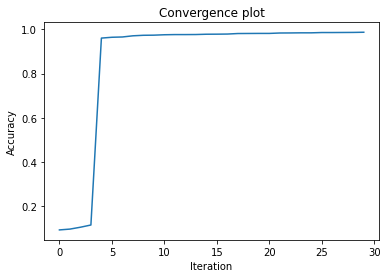

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [21]:
results.head()

,number,value,datetime_start,datetime_complete,duration,params_activation0,params_activation1,params_activation2,params_filters_0,params_filters_1,...,params_num_conv_layers,params_num_dense_layers,params_optimizer_name,params_strides0,params_strides1,params_strides2,params_units0,params_units1,params_units2,state
0,0,0.976190,2022-11-02 06:25:16.585833,2022-11-02 06:26:06.962406,0 days 00:00:50.376573,relu,relu,tanh,64,16.0,...,3,1,Adam,2,2.0,1.0,313,NaN,NaN,COMPLETE
1,1,0.965344,2022-11-02 06:26:07.203034,2022-11-02 06:26:28.220684,0 days 00:00:21.017650,tanh,relu,tanh,16,NaN,...,1,3,Adam,2,NaN,NaN,54,194.0,221.0,COMPLETE
2,2,0.976455,2022-11-02 06:26:28.524815,2022-11-02 06:27:32.638142,0 days 00:01:04.113327,tanh,tanh,NaN,16,32.0,...,2,1,Adam,2,1.0,NaN,75,NaN,NaN,COMPLETE
3,3,0.981481,2022-11-02 06:27:32.890276,2022-11-02 06:27:53.049733,0 days 00:00:20.159457,relu,NaN,NaN,64,NaN,...,1,1,Adam,2,NaN,NaN,127,NaN,NaN,COMPLETE
4,4,0.973545,2022-11-02 06:27:53.349801,2022-11-02 06:28:25.034381,0 days 00:00:31.684580,tanh,NaN,NaN,64,NaN,...,1,1,RMSprop,2,NaN,NaN,498,NaN,NaN,COMPLETE


## Evaluate the model

In [22]:
# load best model

model = load_model(path_best_model)

In [23]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 12544)             0         
                                                                 
 dense_39 (Dense)            (None, 261)               3274245   
                                                                 
 dense_40 (Dense)            (None, 10)                2620      
                                                                 
Total params: 3,278,529
Trainable params: 3,278,529
Non-trainable params: 0
___________________________________________

In [24]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 7ms/step - loss: 0.0613 - accuracy: 0.9836


In [25]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06131227687001228
accuracy 0.9835714101791382


### Confusion matrix

In [26]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[416,   0,   0,   1,   1,   1,   2,   0,   1,   0],
       [  0, 470,   1,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 406,   0,   0,   0,   1,   0,   2,   0],
       [  0,   0,   2, 416,   0,   7,   0,   1,   0,   0],
       [  1,   3,   0,   0, 423,   0,   1,   0,   1,   0],
       [  0,   0,   0,   3,   0, 376,   2,   0,   1,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   0,   0],
       [  0,   2,   5,   1,   1,   1,   0, 457,   0,   2],
       [  0,   1,   1,   1,   0,   0,   6,   0, 375,   0],
       [  1,   0,   0,   1,   6,   1,   1,   2,   1, 381]])

Text(0.5, 13.421126458070283, 'Predicted label')

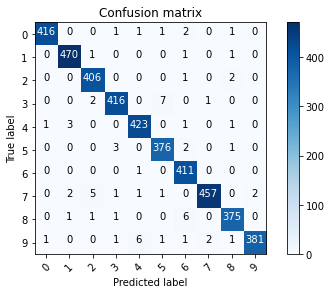

In [27]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')